# GPS_Preprocess

GPS preprocessing in acccordance with Mueller et al. (2021): https://www.nature.com/articles/s41598-021-93087-x) and https://osf.io/rekuw/?view_only=f3fa7eda583940e4b68f39000ad92c45 

In [1]:
import os
import sys

import glob
import pickle
from IPython.display import Markdown
from config import datapath

# If your current working directory is the notebooks directory, use this:
library_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'library'))
sys.path.append(library_path)

from gps_features import haversine, identify_home,calculate_metrics, calculate_transition_time, adaptive_kmeans, apply_clustering, calculate_intraclass_coefficient

import pandas as pd
import numpy as np
import datetime as dt

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from math import radians, cos, sin, asin, sqrt
import statistics 
import scipy.stats as stats
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns 
sns.set_context("notebook", rc={"axes.labelsize": 14, "xtick.labelsize": 14, "ytick.labelsize": 14})
sns.set_style("whitegrid", {'axes.grid': True})
%matplotlib inline

In [2]:
today = dt.date.today().strftime("%d%m%Y")
today_day = pd.to_datetime('today').normalize()

with open(datapath + f'ema_data.pkl', 'rb') as file:
    df_active = pickle.load(file)

with open(datapath + f'gps_data.pkl', 'rb') as file:
    df_gps = pickle.load(file)
    
with open(datapath + f'passive_data.pkl', 'rb') as file:
    df_passive = pickle.load(file)

with open(datapath + f'monitoring_data.pkl', 'rb') as file:
    df_monitoring = pickle.load(file)

## Configurations

In [3]:
min_hour_daily = 8
min_days_data = 12

#stationary filtering
max_distance = 150 
speed_limit = 1.4  # Max allowed speed in m/s

# DBSCAN
kms_per_radian = 6371.0088 # equitorial radius of the earth = 6,371.1 
epsilon = 0.03/kms_per_radian
min_samples = 10

# Kmeans
DKmeans = 500

#home featurenight
min_nights_obs = 5
min_f_home = 0.5   


## Prepare the PD dataframe

In [4]:
df_passive = df_passive.loc[df_passive.status.isin(["Abgeschlossen", "Post_Erhebung_1",
                                                             "Erhebung_2_aktiv","Post_Erhebung_2"])]
df_passive = df_passive[df_passive['startTimestamp'] <= df_passive['ema_end_date']]

In [5]:
df_steps = df_passive.loc[df_passive.type.isin(['Steps'])][["customer","type","startTimestamp",  "endTimestamp", "doubleValue",
                                                      'startTimestamp_day','startTimestamp_hour', 'ema_start_date','ema_end_date']]

In [6]:
df_steps

,customer,type,startTimestamp,endTimestamp,doubleValue,startTimestamp_day,startTimestamp_hour,ema_start_date,ema_end_date
2,4Twz,Steps,2024-03-05 16:59:00,2024-03-05 17:00:00,6.0,2024-03-05,16,2024-03-05,2024-03-20
5,4Twz,Steps,2024-03-05 17:00:00,2024-03-05 17:01:00,11.0,2024-03-05,17,2024-03-05,2024-03-20
8,4Twz,Steps,2024-03-05 17:01:00,2024-03-05 17:02:00,7.0,2024-03-05,17,2024-03-05,2024-03-20
43,4Twz,Steps,2024-03-05 17:03:00,2024-03-05 17:04:00,13.0,2024-03-05,17,2024-03-05,2024-03-20
47,4Twz,Steps,2024-03-05 17:04:00,2024-03-05 17:05:00,32.0,2024-03-05,17,2024-03-05,2024-03-20
...,...,...,...,...,...,...,...,...,...
18082233,pxsL,Steps,2024-03-01 15:09:00,2024-03-01 15:10:00,8.0,2024-03-01,15,2024-02-16,2024-03-02
18082236,pxsL,Steps,2024-03-01 15:15:00,2024-03-01 15:16:00,9.0,2024-03-01,15,2024-02-16,2024-03-02
18082240,pxsL,Steps,2024-03-01 15:17:00,2024-03-01 15:18:00,15.0,2024-03-01,15,2024-02-16,2024-03-02
18082243,pxsL,Steps,2024-03-01 15:18:00,2024-03-01 15:19:00,8.0,2024-03-01,15,2024-02-16,2024-03-02


In [7]:
# Rename the columns for clarity
df_steps = df_steps.rename(columns={
    'startTimestamp': 'startTimestamp_steps',
    'endTimestamp': 'endTimestamp_steps',
    'startTimestamp_day': 'day_steps',  # Keeping one 'Day' column
    'startTimestamp_hour_Latitude': 'hour_steps'  # Keeping one 'Hour' column
})

In [8]:
df_steps["daily_steps"] = df_steps.groupby(["customer", "day_steps"])["doubleValue"].transform("sum")


In [9]:
df_steps = df_steps[["customer", "day_steps","daily_steps"]].drop_duplicates()

## Prepare the GPS dataframe

In [10]:
# Filter for participants that have finished 1. EMA Phase

df_gps = df_gps.loc[df_gps.status.isin(["Abgeschlossen", "Post_Erhebung_1",
                                                             "Erhebung_2_aktiv","Post_Erhebung_2"])]

In [11]:
df_gps = df_gps[df_gps['startTimestamp'] <= df_gps['ema_end_date']]

In [12]:
df_int = df_gps.pivot_table(
    index=["customer", "startTimestamp", "ema_start_date"],
    columns="type",
    values=["doubleValue", "startTimestamp_hour", "startTimestamp_day"],
    aggfunc='first'  # Using 'first' since each type should theoretically have only one entry per customer and timestamp
)

# Flatten the MultiIndex in columns
df_int.columns = ['_'.join(col).strip() for col in df_int.columns.values]

df_int = df_int.rename_axis(None, axis=1).reset_index()

# Drop redundant day and hour columns for longitude (assuming latitude day and hour are kept)
df_int = df_int.drop(columns=[
    'startTimestamp_day_Longitude',
    'startTimestamp_hour_Longitude'
])

# Rename the columns for clarity
df_int = df_int.rename(columns={
    'doubleValue_Latitude': 'Latitude',
    'doubleValue_Longitude': 'Longitude',
    'startTimestamp_day_Latitude': 'day_gps',  # Keeping one 'Day' column
    'startTimestamp_hour_Latitude': 'hour_gps'  # Keeping one 'Hour' column
})

df_int['weekday'] = df_int['day_gps'].dt.day_name()
df_int["n_hours"] = df_int.groupby(["customer", "day_gps"])["hour_gps"].transform("nunique")
df_int["n_data"] = df_int.groupby("customer")["Longitude"].transform("size")
df_int["n_data_day"] = df_int.groupby(["customer", "day_gps"])["Longitude"].transform("size")
df_int["n_data_hour"] = df_int.groupby(["customer", "hour_gps"])["Longitude"].transform("size")

df_int = df_int.loc[df_int["n_hours"] >= min_hour_daily]
df_int["n_days_8"] = df_int.groupby("customer")["day_gps"].transform("nunique")
df_int = df_int.loc[df_int["n_days_8"] >= min_days_data]

# Ensure your DataFrame is sorted by customer and day
df_int = df_int.sort_values(by=['customer', 'day_gps'])

## Descriptive Plots

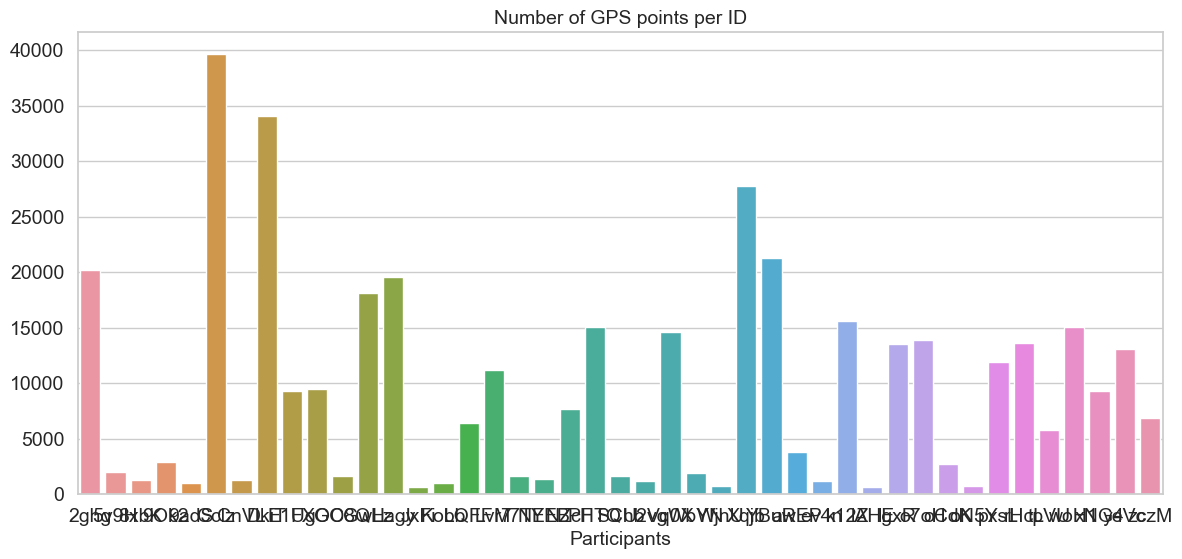

In [13]:
plt.figure(figsize=(14, 6))
sns.barplot(x='customer', y='n_data', data=df_int)
plt.title('Number of GPS points per ID',fontsize=14)
plt.ylabel('')
plt.xlabel('Participants')

#plt.savefig("barplot_high_quality.png", dpi=300, format='png', bbox_inches='tight')
# Showing the plot
plt.show()

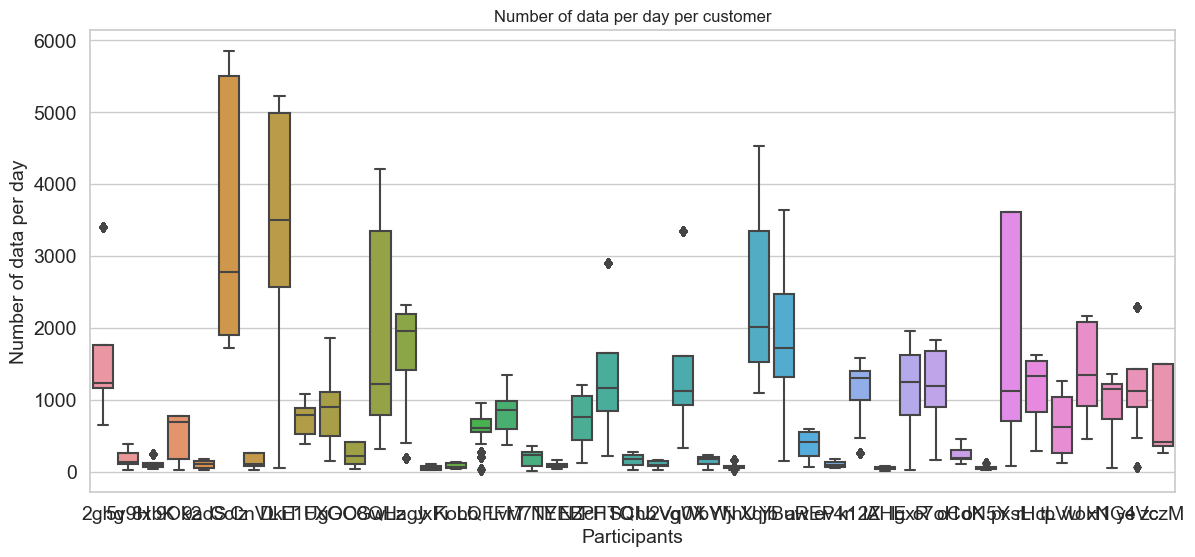

In [14]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='customer', y='n_data_day', data=df_int)
plt.title('Number of data per day per customer')
plt.ylabel('Number of data per day')
plt.xlabel('Participants')

# Showing the plot
plt.show()

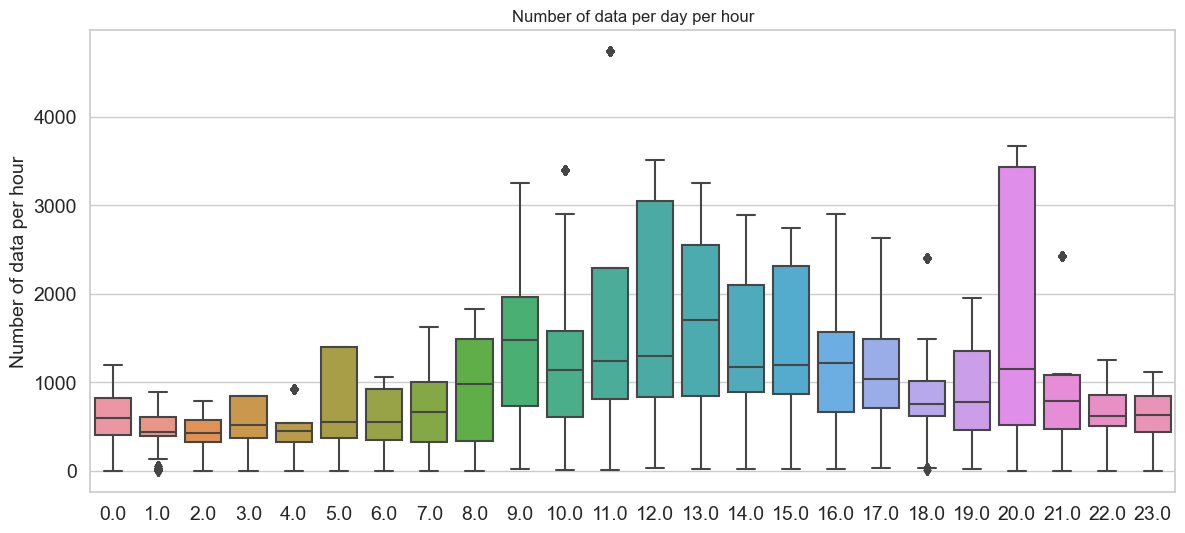

In [15]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='hour_gps', y='n_data_hour', data=df_int)
plt.title('Number of data per day per hour')
plt.ylabel('Number of data per hour')
plt.xlabel('')

# Showing the plot
plt.show()

## Data filtering by converting GPS data to stationary data

In [16]:
df_speed = df_int.copy()


In [17]:
daily_transition_times = calculate_transition_time(df_speed, group_by=['customer', 'day_gps'])
general_transition_times = calculate_transition_time(df_speed, group_by=['customer'])

# Merge the daily and total metrics on 'customer'
merged_transition = pd.merge(daily_transition_times, general_transition_times, on='customer', suffixes=('_daily', '_total'))
df_speed = pd.merge(df_speed, merged_transition,on=["customer", "day_gps"])

In [18]:

# Initializing columns to store calculated values
df_speed['distance'] = np.nan
df_speed['time_diff'] = np.nan
df_speed['speed'] = np.nan

# Calculating distance, time difference, and speed for each customer independently
for customer in df_speed['customer'].unique():
    mask = df_speed['customer'] == customer
    
    df_speed.loc[mask, 'distance'] = np.concatenate([
        haversine(
            df_speed.loc[mask, 'Longitude'].values[:-1], df_speed.loc[mask, 'Latitude'].values[:-1],
            df_speed.loc[mask, 'Longitude'].values[1:], df_speed.loc[mask, 'Latitude'].values[1:]
        ),
        [0]
    ])
    
    df_speed.loc[mask, 'time_diff'] = df_speed.loc[mask, 'startTimestamp'].diff().dt.total_seconds().fillna(0)
    
    # Avoid division by zero and replace NaN if time_diff is 0
    df_speed.loc[mask, 'speed'] = df_speed.loc[mask, 'distance'] / df_speed.loc[mask, 'time_diff'].replace(0, np.nan)


# Creating the stationary DataFrame
stationary_df = df_speed[(df_speed['speed'] < speed_limit) & (df_speed['distance'] < max_distance)]

##  DBSCAN for location clustering

In [19]:
# Group by 'userID' and apply clustering function
geodata_cluster_df = apply_clustering(stationary_df, epsilon, min_samples)


In [20]:
# Merge this with the main data frame
geodata_clusters = pd.concat([stationary_df.reset_index(drop=True), geodata_cluster_df['cluster_100m']], axis=1)

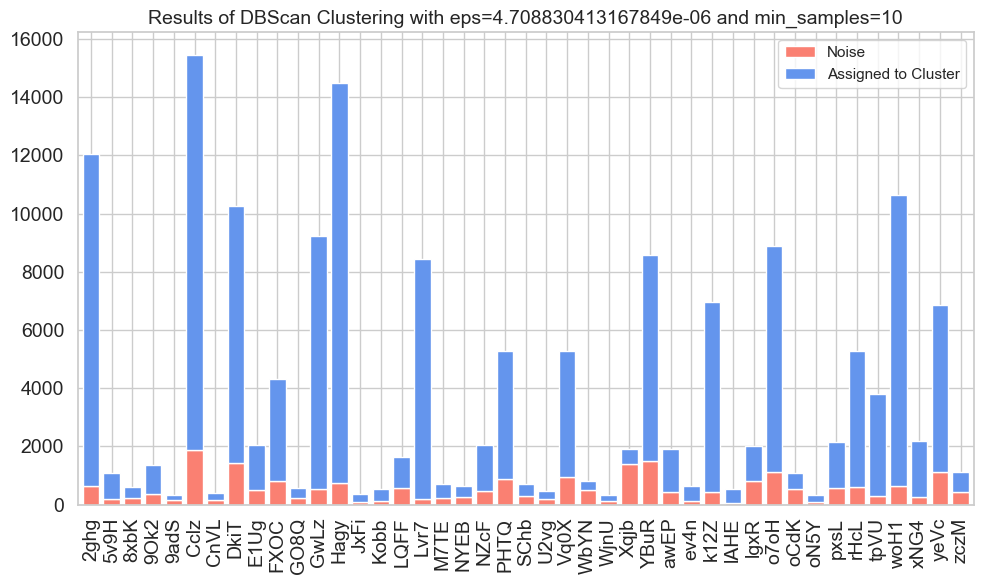

In [21]:
# Initializing a new DataFrame to store processed data
plot_data = pd.DataFrame()

# Calculating the count of "-" values per customer
plot_data['negative_count'] = geodata_clusters[geodata_clusters['cluster_100m'] == -1].groupby('customer').size()

# Calculating the count of non "-" values per customer
plot_data['positive_count'] = geodata_clusters[geodata_clusters['cluster_100m'] != -1].groupby('customer').size()

# Filling NaN with 0s (for customers with no "-" values)
plot_data = plot_data.fillna(0)

# Plotting
ax = plot_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=['salmon', 'cornflowerblue'], width=0.8)
plt.title(f'Results of DBScan Clustering with eps={epsilon} and min_samples={min_samples}',  fontsize=14)
plt.ylabel('')
plt.xlabel('')

# Adjusting the legend
plt.legend(["Noise", "Assigned to Cluster"], loc='upper right')

#plt.savefig('dbscan_count.png', dpi=300)
# Showing the plot
plt.tight_layout()
plt.show()

In [22]:
geodata_clusters = geodata_clusters[geodata_clusters['cluster_100m'] != -1]

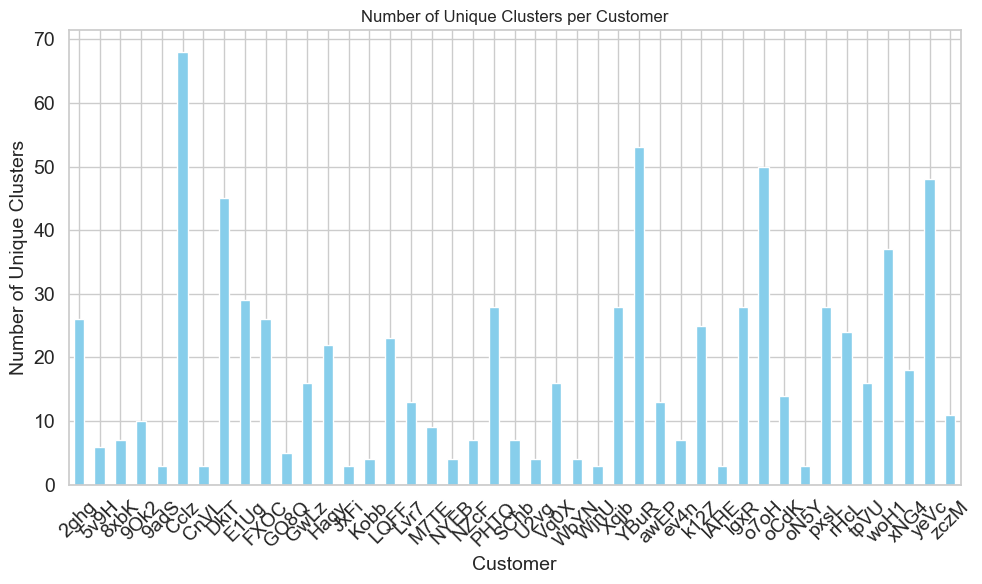

In [23]:
# Count unique clusters per customer
unique_clusters = geodata_cluster_df.groupby('customer')['cluster_100m'].nunique()
# Plotting
unique_clusters.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.xlabel('Customer')
plt.ylabel('Number of Unique Clusters')
plt.title('Number of Unique Clusters per Customer')
plt.xticks(rotation=45)  # Rotate labels to avoid overlap, adjust as necessary
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
plt.show()

In [24]:
# Generate unique IDs for clusters
geodata_clusters['clusterID'] = geodata_clusters['customer'].astype(str) + '00' + \
geodata_clusters['cluster_100m'].astype(str)

## Generate Home Location from data

In [25]:
# Filter data for night hours (midnight to 6:00 am)
geodata_night = geodata_clusters.loc[(geodata_clusters['hour_gps'] >= 20) | (geodata_clusters['hour_gps'] <= 6)]

# Find the mode of clusterID per user during night hours
geodata_night = geodata_night.copy()
geodata_night['home'] = geodata_night.groupby('customer')['clusterID'].transform(lambda x: statistics.mode(x))

In [26]:
# Calculating various metrics to validate the home cluster
geodata_night['nights_with_obs'] = geodata_night.groupby('customer')['day_gps'].transform('nunique')
geodata_night['night_obs'] = geodata_night.groupby('customer')['day_gps'].transform('size')


In [27]:
# Finding the frequency of the mode
geodata_night['n_home'] = geodata_night.groupby('customer')['home'].transform(lambda x: x.value_counts().iloc[0])
geodata_night['f_home'] = geodata_night['n_home'] / geodata_night['night_obs']

# Updating the 'home' label based on conditions
geodata_night['home'] = geodata_night.apply(
    lambda x: x['home'] if x['nights_with_obs'] >= min_nights_obs and x['f_home'] > min_f_home else None, axis=1
)

# Extracting a mapping of userID to home cluster
user_home_mapping = geodata_night[['customer', 'home']].drop_duplicates()

# Merging back to the full dataset
geodata_clusters = pd.merge(geodata_clusters, user_home_mapping, on='customer', how='left')

In [30]:
general_entropy = calculate_metrics(geodata_clusters, group_by=['customer'])
daily_entropy = calculate_metrics(geodata_clusters, group_by=['customer', 'day_gps'])

merged_metrics = pd.merge(daily_entropy, general_entropy, on='customer', suffixes=('_daily', '_total'))
geodata_clusters = pd.merge(geodata_clusters, merged_metrics, on=["customer", "day_gps"])

## Merge with Activity data

In [31]:
geodata_cluster_red = geodata_clusters[['customer','day_gps','n_hours', 'n_data', 'n_data_day', 'n_data_hour',
       'n_days_8', 'transition_time_daily', 'transition_time_total',
       'distance', 'time_diff', 'speed', 'cluster_100m', 'clusterID', 'home',
       'raw_entropy_daily', 'normalized_entropy_daily', 'total_distance_daily',
       'percentage_time_at_home_daily', 'num_unique_clusters_daily',
       'num_total_clusters_daily', 'raw_entropy_total',
       'normalized_entropy_total', 'total_distance_total',
       'percentage_time_at_home_total', 'num_unique_clusters_total',
       'num_total_clusters_total', 'home']]

In [32]:
geodata_cluster_red = geodata_cluster_red.drop_duplicates(subset=['customer', 'day_gps'])


In [33]:
activity_merged = pd.merge(geodata_cluster_red, df_steps, left_on=["customer", "day_gps"], 
                           right_on=["customer", "day_steps"], how="inner")

In [34]:
selected_columns = [
    'daily_steps', 
    'n_data_day', 
    'total_distance_daily', 
    'num_unique_clusters_total', 
    'num_total_clusters_total',
    'num_total_clusters_daily',
    'num_unique_clusters_daily',
    'percentage_time_at_home_daily',
    'percentage_time_at_home_total'
]

In [35]:
activity_merged = activity_merged[selected_columns]

In [36]:
activity_merged_numeric = activity_merged.apply(pd.to_numeric, errors='coerce')

In [37]:

# Log transform the right-skewed variables
skewed_variables = ['daily_steps','n_data_day', 'total_distance_daily', 
                    'num_unique_clusters_total', 'num_total_clusters_total',
                    'num_total_clusters_daily', 'num_unique_clusters_daily',
                    'percentage_time_at_home_daily', 'percentage_time_at_home_total']

for variable in skewed_variables:
    activity_merged_numeric[f'{variable}_log'] = np.log1p(activity_merged_numeric[variable])
